The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Calibrate Camera

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

# read in a calibration image
class Calibrate():
    def __init__(self):
        super().__init__()
        
        self.objpoints = []
        self.imgpoints = []
        
        self.data_file = "calibrate.p"
        
        self.image = None
        
        self.mtx = None
        self.dist = None
        
        self.gray = None
        self.data = None
        
    # returns the img and obj points given a board of nx, ny dimensions
    def get_points(self, nx, ny, file_pattern):
        image_files = glob.glob(file_pattern)
        
        for fn in image_files:
            
            #read the image
            image = cv2.imread(fn) #cv2 loads images in BGR
            objp = np.zeros((nx*ny, 3), np.float32)
            objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            
            #convert to grayscale
            self.gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            ret, corners = cv2.findChessboardCorners(self.gray, (nx, ny), None)
            
            if ret == True:
                #print("corners found for", fn)
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
            #else:
                #print("corners not found", fn)
        return self.objpoints, self.imgpoints
    
    def save(self):
        print("saving data into", self.data_file)
        data = {'objpoints':self.objpoints, 'imgpoints':self.imgpoints}
        pickle.dump(data, open( self.data_file, "wb"))
        
    def load(self):
        print("loading data file", self.data_file)
        
        with open(self.data_file, mode="rb") as f:
            data= pickle.load(f)
            
            self.objpoints = data['objpoints']
            self.imgpoints = data['imgpoints']
    
    # recieves as input an unprocessed image
    # uses stored calibration to undistort it
    def undistort_image(self, img):
        self.gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # if we don't have a defined mtx
        if (self.mtx == None):
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, self.gray.shape[::-1], None, None)
            self.mtx = mtx
            self.dist = dist
        
        #undistort the image
        undist_img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist_img         

cal = Calibrate()

cal.get_points(9, 6, './camera_cal/calibration*.jpg')

# images where the board is not fully visible
cal.get_points(9, 5, './camera_cal/calibration1.jpg')
cal.get_points(8, 6, './camera_cal/calibration4.jpg')
cal.get_points(7, 6, './camera_cal/calibration5.jpg')

cal.save()
    





saving data into calibrate.p


loading data file calibrate.p


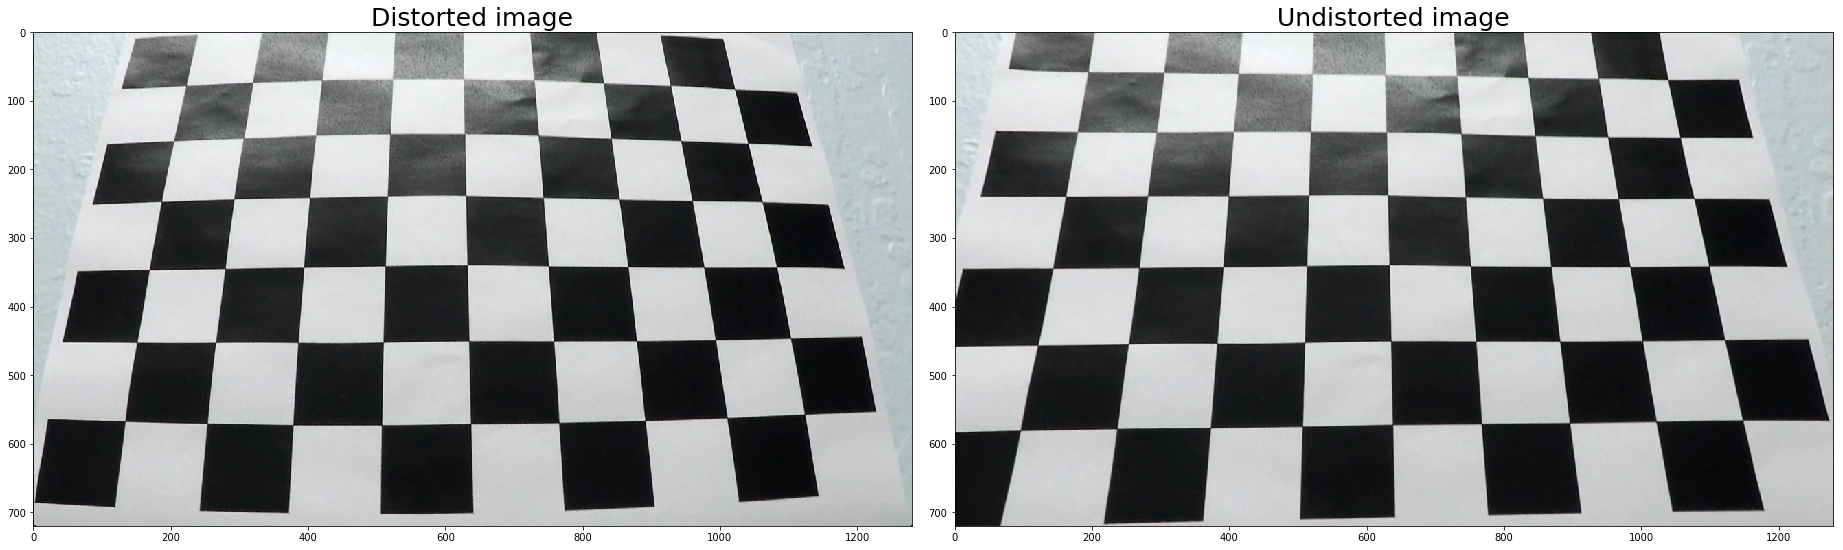

In [12]:
new_cal = Calibrate()
new_cal.load()


# displays original and undistorted images
# receives as input a calibration object and path to image
def debug_undistort(cal, img):
    
    image = cv2.imread(img)
    cal_image = new_cal.undistort_image(image)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Distorted image', fontsize=25)
    ax2.imshow(cal_image)
    ax2.set_title('Undistorted image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cal2 = './camera_cal/calibration3.jpg'

debug_undistort(new_cal, cal2)

# Perspective Transform 

In [3]:
# Apply perspective transform
def warp_image(img,src,dst,img_size):
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv


def debug_warp(cal, img, nx, ny):
    image = cv2.imread(img)
    undist = cal.undistort_image(image)
    ret, corners = cv2.findChessboardCorners(undist, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (undist.shape[1], undist.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        warped_image, perspective_M, inverse_M = warp_image(undist, src, dst, img_size)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped_image)
        ax2.set_title('Undistorted and Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
def apply_perspective_transform(image):
    src = np.float32([
        [580, 460],
        [700, 460],
        [1040, 680],
        [260, 680],
    ])

    dst = np.float32([
        [260, 0],
        [1040, 0],
        [1040, 720],
        [260, 720],
    ])

    warped_image, perspective_M, inverse_M = warp_image(image,src,dst,(img_size[1],img_size[0]))
    return warped_image, perspective_M, inverse_M

In [4]:
cal = Calibrate()
cal.load()

loading data file calibrate.p


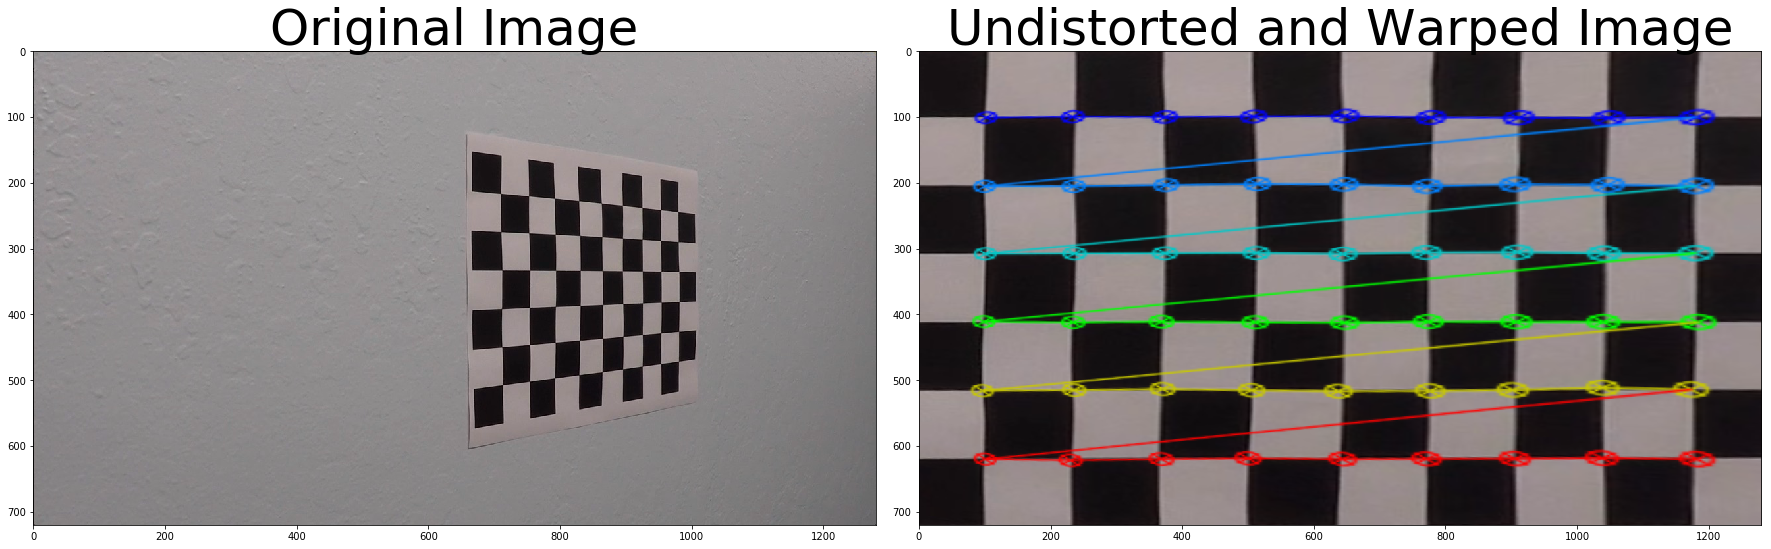

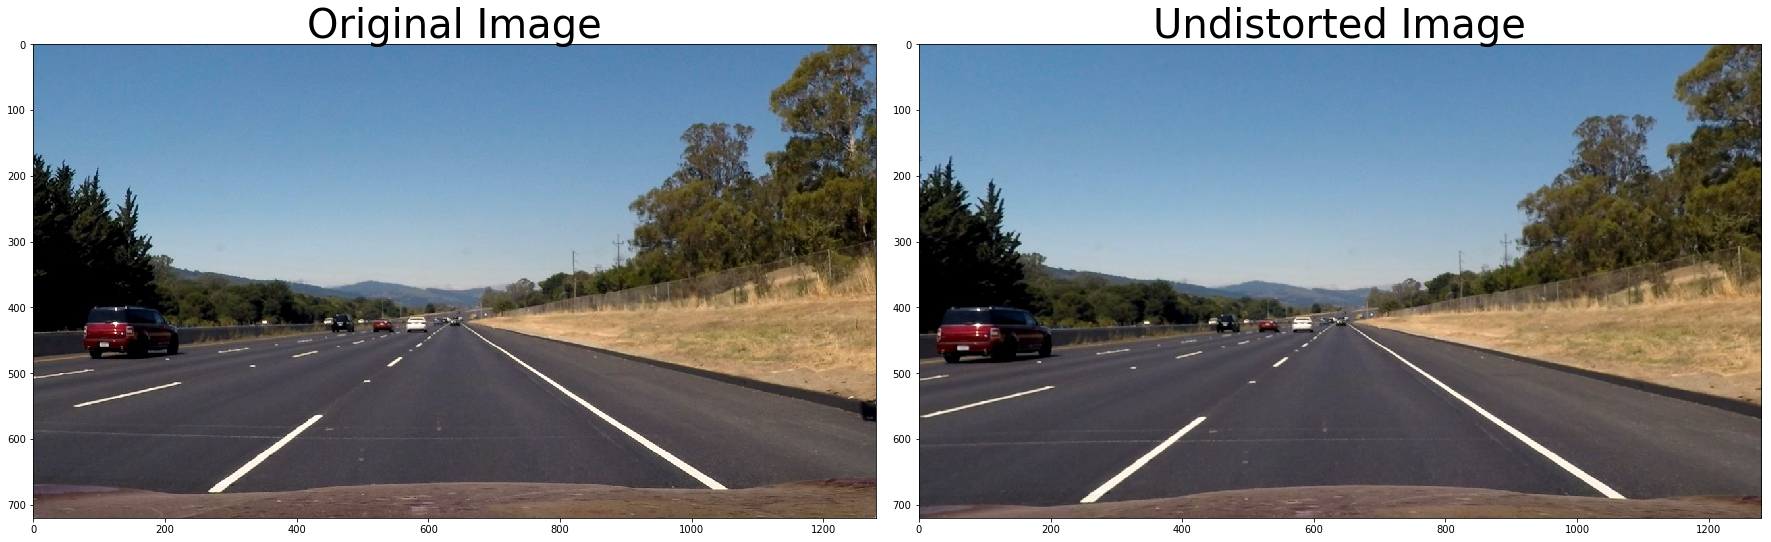

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [14]:



cal2 = './camera_cal/calibration8.jpg'
debug_warp(cal, cal2, 9, 6)

# cal2 = './camera_cal/calibration13.jpg'
# debug_warp(new_cal, cal2, 9, 6)

# image_files = glob.glob('./camera_cal/calibration*.jpg')
        
# for fn in image_files:
#     debug_warp(new_cal, fn, 9, 6)

# Visualize with test

orig_image = './test_images/straight_lines2.jpg'
orig_image = mpimg.imread(orig_image)
undist_image = cal.undistort_image(orig_image)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(orig_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist_image)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistorted_test.jpg')


img_size = np.shape(undist_image)
trans_image, perspective_M, inverse_M = apply_perspective_transform(undist_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(trans_image)
ax2.set_title('Perspective Transform Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/perspective_transform.jpg')



# Gradient Threshold

In [6]:
class Thresholder:
    def __init__(self):
        self.sobel_kernel = 15

        # .7, 1.3
        self.thresh_dir_min = 0.7
        self.thresh_dir_max = 1.2

        # 20, 100
        self.thresh_mag_min = 20
        self.thresh_mag_max = 100
        
    # sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    # Calculate the absolute value of the x derivative
    # abs_sobelx = np.absolute(sobelx)

    # Convert the absolute value image to 8-bit
    # scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # thresh_min = 20
    # thresh_max = 100
    # sxbinary = np.zeros_like(scaled_sobel)
    # sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # plt.imshow(sxbinary, cmap='gray')



    # Define a function that takes an image, gradient orientation,
    # and threshold min / max values.

    # Define a function to threshold an image for a given range and Sobel kernel
    def dir_threshold(self, sobelx, sobely):
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        abs_sobelx = np.abs(sobelx)
        abs_sobely = np.abs(sobely)
        scaled_sobel = np.arctan2(abs_sobely, abs_sobelx)
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= self.thresh_dir_min) & (scaled_sobel <= self.thresh_dir_min)] = 1

        # Return the binary image
        return binary_output

    # dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    # Define a function to return the magnitude of the gradient
    # for a given sobel kernel size and threshold values
    def mag_threshold(self, sobelx, sobely):
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= self.thresh_mag_min) & (gradmag <= self.thresh_mag_max)] = 1

        # Return the binary image
        return binary_output

    # mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))


    def color_threshold(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        yellow_min = np.array([15, 100, 120], np.uint8)
        yellow_max = np.array([80, 255, 255], np.uint8)
        yellow_mask = cv2.inRange(image, yellow_min, yellow_max)

        white_min = np.array([0, 0, 200], np.uint8)
        white_max = np.array([255, 30, 255], np.uint8)
        white_mask = cv2.inRange(image, white_min, white_max)

        binary_output = np.zeros_like(image[:, :, 0])
        binary_output[((yellow_mask != 0) | (white_mask != 0))] = 1

        filtered = image
        filtered[((yellow_mask == 0) & (white_mask == 0))] = 0

        return binary_output
    


    def threshold(self, img):
        sobelx = cv2.Sobel(img[:, :, 2], cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(img[:, :, 2], cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)

        direc = self.dir_threshold(sobelx, sobely)
        mag = self.mag_threshold(sobelx, sobely)
        color = self.color_threshold(img)

        combined = np.zeros_like(direc)
        combined[((color == 1) & ((mag == 1) | (direc == 1)))] = 1

        return combined

# Color Spaces

In [7]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# hls_binary = hls_select(image, thresh=(90, 255))

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

In [8]:
# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
# bottom_left = [320,720] 
# bottom_right = [920, 720]
# top_left = [320, 1]
# top_right = [920, 1]

# dst = np.float32([bottom_left,bottom_right,top_right,top_left])
# M = cv2.getPerspectiveTransform(source, dst)
# M_inv = cv2.getPerspectiveTransform(dst, source)
# img_size = (image_shape[1], image_shape[0])

# warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(copy)
# ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(warped, cmap='gray')
# ax2.set_title('Warped Image', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
class Polyfitter:
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.leftx = None
        self.rightx = None
   
    def draw(self, img, left_fit, right_fit, Minv):
        color_warp = np.zeros_like(img).astype(np.uint8)

        fity = np.linspace(0, img.shape[0] - 1, img.shape[0])
        left_fitx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
        right_fitx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]

        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
        pts = np.hstack((pts_left, pts_right))
        pts = np.array(pts, dtype=np.int32)

        cv2.fillPoly(color_warp, pts, (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

        return result
    
    def polyfit(self, img):
        if self.left_fit is None:
            return self.polyfit_sliding(img)
        else:
            nonzero = img.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 100
            left_lane_inds = (
            (nonzerox > (self.left_fit[0] * (nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[2] - margin)) & (
            nonzerox < (self.left_fit[0] * (nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[2] + margin)))
            right_lane_inds = (
            (nonzerox > (self.right_fit[0] * (nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[2] - margin)) & (
            nonzerox < (self.right_fit[0] * (nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[2] + margin)))

            self.leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            self.rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            self.left_fit = np.polyfit(lefty, self.leftx, 2)
            self.right_fit = np.polyfit(righty, self.rightx, 2)
            
            # Generate x and y values for plotting
            ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
            left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
            right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
            
            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((img, img, img))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#             misc.imsave('output_images/viz2.jpg', result)
        
        return self.left_fit, self.right_fit
    
    def polyfit_sliding(self, img):
        histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
        out_img = np.dstack((img, img, img)) * 255
        midpoint = np.int(histogram.shape[0] / 2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        window_height = np.int(img.shape[0] / nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        margin = 100
        minpix = 50
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window + 1) * window_height
            win_y_high = img.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        self.leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        self.rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        self.left_fit = np.polyfit(lefty, self.leftx, 2)
        self.right_fit = np.polyfit(righty, self.rightx, 2)

        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#         misc.imsave('output_images/viz.jpg', out_img)
        
        return self.left_fit, self.right_fit

    def measure_curvature(self, img):
        ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
        quadratic_coeff = 3e-4  # arbitrary quadratic coefficient
        leftx = np.array([200 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                          for y in ploty])
        rightx = np.array([900 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                           for y in ploty])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

#         left_fit = np.polyfit(ploty, leftx, 2)
#         left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#         right_fit = np.polyfit(ploty, rightx, 2)
#         right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        y_eval = np.max(ploty)
        # left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
        # right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
        # print(left_curverad, right_curverad)

        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

        left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
        # print(left_curverad, 'm', right_curverad, 'm')

        lane_leftx = self.left_fit[0] * (img.shape[0] - 1) ** 2 + self.left_fit[1] * (img.shape[0] - 1) + self.left_fit[2]
        lane_rightx = self.right_fit[0] * (img.shape[0] - 1) ** 2 + self.right_fit[1] * (img.shape[0] - 1) + self.right_fit[2]

        car_pos = ((img.shape[1] / 2) - ((lane_leftx + lane_rightx) / 2)) * xm_per_pix

#         return (left_curverad + right_curverad) / 2, car_pos.round(2)
        return left_curverad, right_curverad, car_pos.round(2)

In [10]:
from scipy import misc
from moviepy.video.io.VideoFileClip import VideoFileClip
thresholder = Thresholder()
polyfitter = Polyfitter()

def process_image(image):
    undist_image = cal.undistort_image(image)

#     misc.imsave('output_images/undist.jpg', undist_image)

    thresh_image = thresholder.threshold(undist_image)
#     misc.imsave('output_images/threshold.jpg', thresh_image)

    trans_image, perspective_M, inverse_M = apply_perspective_transform(thresh_image)
#     misc.imsave('output_images/warped.jpg', trans_image)

    left_fit, right_fit = polyfitter.polyfit(trans_image)

    img = polyfitter.draw(undist_image, left_fit, right_fit, inverse_M)
#     misc.imsave('output_images/final.jpg', img)
    
    left_curverad, right_curverad, car_pos = polyfitter.measure_curvature(img)
    if car_pos > 0:
        car_pos_text = '{}m right of center'.format(car_pos)
    else:
        car_pos_text = '{}m left of center'.format(abs(car_pos))

    cv2.putText(img, "Radius of Left Curvature:: {}m".format(left_curverad.round()), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color=(255, 255, 255), thickness=2)
    cv2.putText(img, "Radius of Right Curvature:: {}m".format(right_curverad.round()), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color=(255, 255, 255), thickness=2)
    cv2.putText(img, "Car is {}".format(car_pos_text), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255, 255, 255),
                thickness=2)

    return img

# orig_image = './test_images/test3.jpg'
# orig_image = mpimg.imread(orig_image)
# result = process_image(orig_image)
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:59<00:00,  5.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min
